In [28]:
import pandas as pd
import numpy as np

# Read in data from the three locations (Lonzee, Selhausen Juelich, and Voulundgaard)
# Make some changes to the columns so the dataframes can be combined later
lon_data = pd.read_csv('data/Lon_data.csv')
lon_data["Location"] = 'Lonzee'
lon_data = lon_data.rename(
    columns={"SW_IN_1_1_2":"Incoming_shortwave_radiation"})
lon_data = lon_data.replace(to_replace='#DIV/0!',value=np.nan)
print('Lonzee:',lon_data.shape)

rus_data = pd.read_csv('data/RuS_data.csv')
rus_data["Location"] = 'Selhausen Juelich'
rus_data = rus_data.drop(columns='RECO_DT_VUT_REF.1')
rus_data = rus_data.rename(
    columns={"SW_IN_1_1_2":"Incoming_shortwave_radiation"})
print('Selhausen Juelich:',rus_data.shape)

vou_data = pd.read_csv('data/vou_data.csv')
vou_data["Location"] = 'Voulundgaard'
vou_data = vou_data.rename(
    columns={"SW_IN_1_1_1":"Incoming_shortwave_radiation"})
cols_to_drop = lon_data.columns.symmetric_difference(vou_data.columns)
vou_data = vou_data.drop(columns=cols_to_drop)
print('Voulundgaard:',vou_data.shape)

# Combine data from different locations into single dataframe
frames = [lon_data,rus_data,vou_data]
data = pd.concat(frames)
print('All data:',data.shape)

C:\Users\sharp\AppData\Local\Temp\ipykernel_15536\4127769267.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  lon_data = pd.read_csv('data/Lon_data.csv')


Lonzee: (87648, 25)
Selhausen Juelich: (70128, 25)
Voulundgaard: (52608, 25)
All data: (210384, 25)


In [29]:
# Make location 1st column
data = data[['Location'] + [col for col in data.columns if col != 'Location']]

# Replace -9999 with NaN
data = data.replace(to_replace=-9999,value=np.nan)

# Convert TIMESTAMP_START to datetime format
data['TIMESTAMP_START'] = pd.to_datetime(data['TIMESTAMP_START'].round(0),
                                         format="%Y%m%d%H%M")
data['TIMESTAMP_END'] = pd.to_datetime(data['TIMESTAMP_END'],
                                       format="%Y%m%d%H%M")

# Create year and month columns
data.insert(1,'Hour',data['TIMESTAMP_START'].dt.hour)
data.insert(1,'Day',data['TIMESTAMP_START'].dt.day)
data.insert(1,'Month',data['TIMESTAMP_START'].dt.month)
data.insert(1,'Year',data['TIMESTAMP_START'].dt.year)

# Rename some columns for personal preference
data = data.rename(
    columns={"TA_F": "Air_temperature","P_F":"Precipitation",
             "GPP_DT_VUT_REF":"GPP","NEE_VUT_REF":"NEE","RECO_DT_VUT_REF":"RECO",
             "TS_F_MDS_1":"Soil_temperature_1","TS_F_MDS_2":"Soil_temperature_2",
             "TS_F_MDS_3":"Soil_temperature_3","TS_F_MDS_4":"Soil_temperature_4",
             "TS_F_MDS_5":"Soil_temperature_5","TIMESTAMP_START":"Timestamp_start",
             "TIMESTAMP_END":"Timestamp_end","RH":"Relative_humidity",
             "G_F_MDS":"Soil_heat_flux","SWC_F_MDS_5":"Soil_water_content",
             "SWC_F_MDS_1":"Soil_water_content_1","SWC_F_MDS_2":"Soil_water_content_2",
             "SWC_F_MDS_3":"Soil_water_content_3","SWC_F_MDS_4":"Soil_water_content_4",
             "SWC_F_MDS_5":"Soil_water_content_5","TS_avg":"Avg_soil_temperature",
             })

# Remove 'LE_F_MDS' and 'H_F_MDS' (not sure what these are)
data = data.drop(columns=['LE_F_MDS', 'H_F_MDS', 'RECO_NT_VUT_REF'])
data.head()

,Location,Year,Month,Day,Hour,Timestamp_start,Timestamp_end,Relative_humidity,NEE,Soil_heat_flux,...,Soil_water_content_4,Soil_water_content_5,Soil_temperature_1,Soil_temperature_2,Soil_temperature_3,Soil_temperature_4,Soil_temperature_5,Avg_soil_temperature,Precipitation,Incoming_shortwave_radiation
0,Lonzee,2018,1,1,0,2018-01-01 00:00:00,2018-01-01 00:30:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN
1,Lonzee,2018,1,1,0,2018-01-01 00:30:00,2018-01-01 01:00:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN
2,Lonzee,2018,1,1,1,2018-01-01 01:00:00,2018-01-01 01:30:00,NaN,-0.43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN
3,Lonzee,2018,1,1,1,2018-01-01 01:30:00,2018-01-01 02:00:00,NaN,-0.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN
4,Lonzee,2018,1,1,2,2018-01-01 02:00:00,2018-01-01 02:30:00,NaN,0.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN


In [30]:
cleaned_data = data.dropna()
print('All data:', data.shape)
print('Cleaned data:', cleaned_data.shape)

All data: (210384, 26)
Cleaned data: (152654, 26)


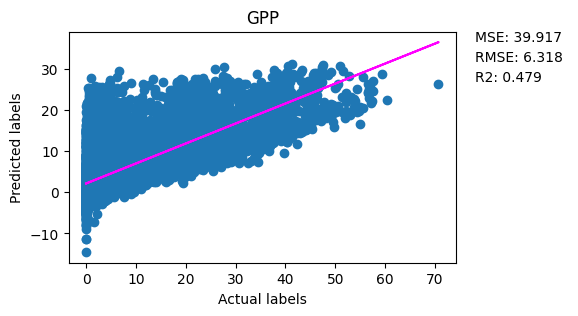

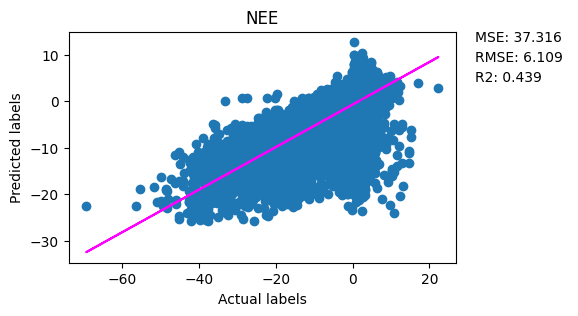

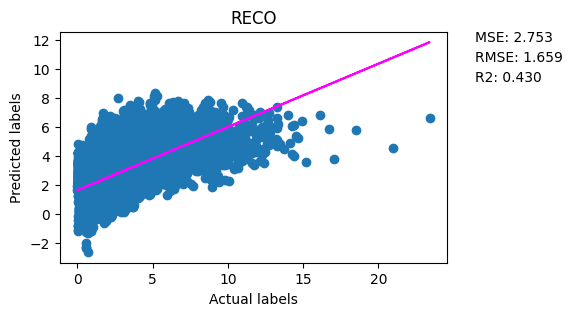

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Select features and labels
labels = ['GPP','NEE','RECO']
features = ['Year', 'Month', 'Day', 'Hour', 'Relative_humidity', 
        'Soil_heat_flux', 'Air_temperature', 'Soil_water_content_1', 
        'Soil_water_content_2', 'Soil_water_content_3', 
        'Soil_water_content_4', 'Soil_water_content_5',
        'Soil_temperature_1', 'Soil_temperature_2', 'Soil_temperature_3',
        'Soil_temperature_4', 'Soil_temperature_5', 'Avg_soil_temperature',
        'Precipitation', 'Incoming_shortwave_radiation']

# Method that tests performance of model given features X and labels y
def test_model(model,X,y):
    predictions = model.predict(X)
    mse = mean_squared_error(y,predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y,predictions)

    fig, ax = plt.subplots(1,1,figsize=(5,3))

    ax.scatter(y, predictions)
    plt.xlabel('Actual labels')
    plt.ylabel('Predicted labels')
    plt.title(label)
    plt.annotate(('MSE: ' + str("{:.3f}".format(mse))),xy=(475, 275), xycoords='figure pixels')
    plt.annotate(('RMSE: ' + str("{:.3f}".format(rmse))),xy=(475, 255), xycoords='figure pixels')
    plt.annotate(('R2: ' + str("{:.3f}".format(r2))),xy=(475, 235), xycoords='figure pixels')

    # overlay the regression line
    z = np.polyfit(np.squeeze(np.asarray(y)), predictions, 1)
    p = np.poly1d(np.squeeze(z))
    plt.plot(y,p(y),color='magenta')
    plt.show()

    return fig, ax

for label in labels:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(cleaned_data[features],cleaned_data[label],
                                                        test_size=0.1, random_state=42)

    # Train linear regression model
    linear_reg_model = LinearRegression().fit(X_train, y_train)

    # Plot model results
    fig, ax = test_model(linear_reg_model,X_test,y_test)

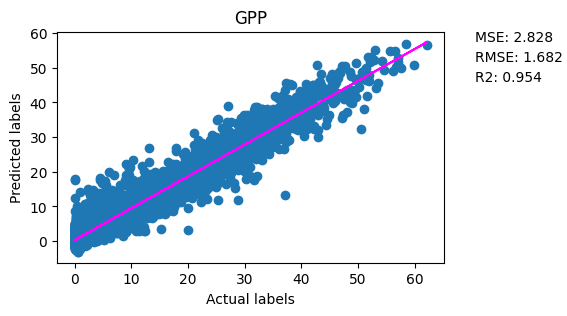

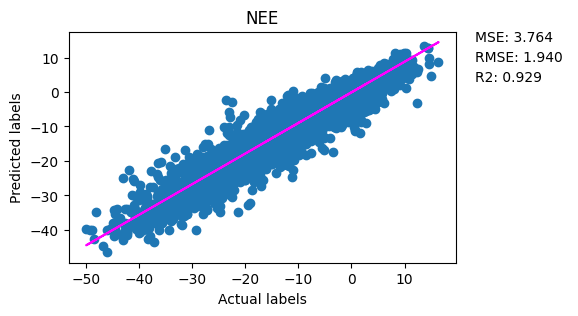

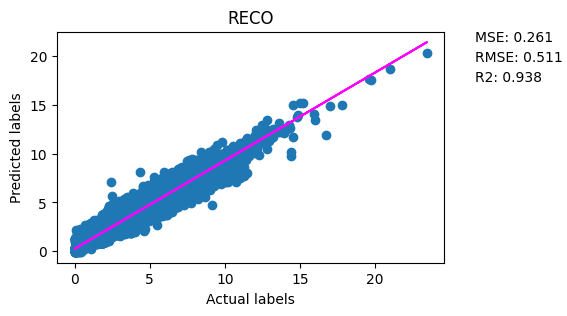

In [32]:
for label in labels:
    X_train, X_test, y_train, y_test = train_test_split(data[features],data[label],
                                                        test_size=0.1, random_state=42)
    HGBR_model = HistGradientBoostingRegressor().fit(X_train, y_train)
    fig, ax = test_model(HGBR_model,X_test,y_test)